# Import Modules

In [1]:
from math import ceil
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import os

import matplotlib.pyplot as plt

import torch.utils.data as td
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
from collections import defaultdict

import numpy as np
# from scipy.signal import savgol_filter
import time
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from PIL import Image
import numpy as np
from sklearn.manifold import TSNE
import pickle

import json
from PIL import Image as PilImage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Setting Path

In [2]:
path = new_path = "/kaggle/input/comp6321-project-datasets/Dataset 3/Dataset 3/Animal Faces"
subDirectories = os.listdir(new_path)

# Set Device to GPU

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Reading Labels of Dataset

In [4]:
def read_label(subDirectories):
    print(subDirectories)
    enu = range(len(subDirectories))
    labels_map={}
    for enu,subDirectory in enumerate(subDirectories):
        labels_map.update({enu:subDirectory})
    print(labels_map)
    print("The number of labels in the dataset = %s"% len(labels_map))
    print("The \'%s\' device is being used to process the dataset"%device)
    return labels_map

In [5]:
labels_map = read_label(subDirectories)

['dog', 'wild', 'cat']
{0: 'dog', 1: 'wild', 2: 'cat'}
The number of labels in the dataset = 3
The 'cuda' device is being used to process the dataset


# Display Dataset Images

In [6]:
def displayImages(t_dataset,imageFlag):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    if imageFlag==0:
      figure.suptitle("Images before preprocessing")
    else:
     figure.suptitle("Images after preprocessing")   
    for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(t_dataset), size=(1,)).item()
      img, label = t_dataset[sample_idx]
      img=np.array(img).transpose((1,2,0))
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.squeeze())
    print("\n\n\n################################################\n\n\n")
    plt.show()

# Load Data

In [7]:
def data_loader(data_dir_input,batch_sizeGiven,input_size,flag=0,test_split=1):
# Define dataset directory and transforms
  data_dir = data_dir_input #
  
  data_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.554, 0.450, 0.343],[0.231, 0.241, 0.241]),
  ])


  if flag==1:
    test_temp_dataset = datasets.ImageFolder(data_dir,transform=transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),   
  ]))
    displayImages(test_temp_dataset,0)
    test_temp_dataset = datasets.ImageFolder(data_dir,transform=data_transform)
    displayImages(test_temp_dataset,1)

    return  

  data = datasets.ImageFolder(root=data_dir, transform=data_transform)
  test_loader = DataLoader(data, batch_size=batch_sizeGiven, shuffle=True, drop_last=False, num_workers=0,pin_memory=True)

  return test_loader

# Dataset Images before and after Preprocessing




################################################





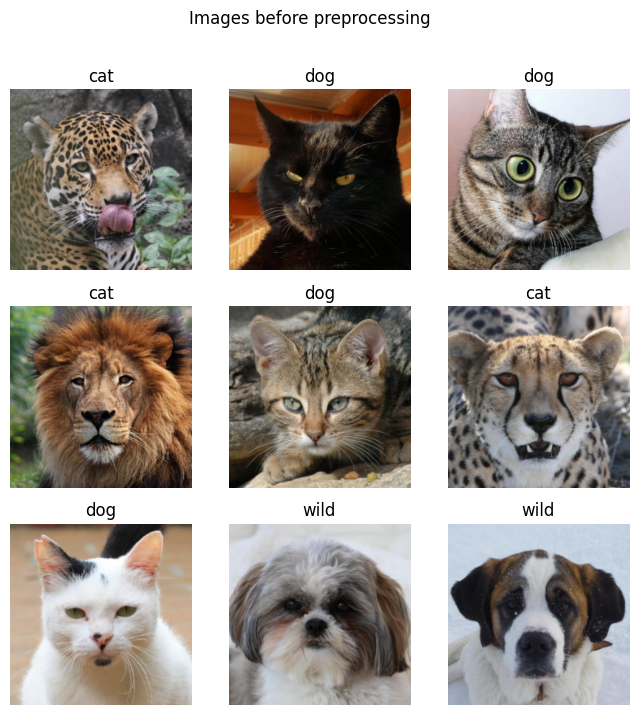




################################################





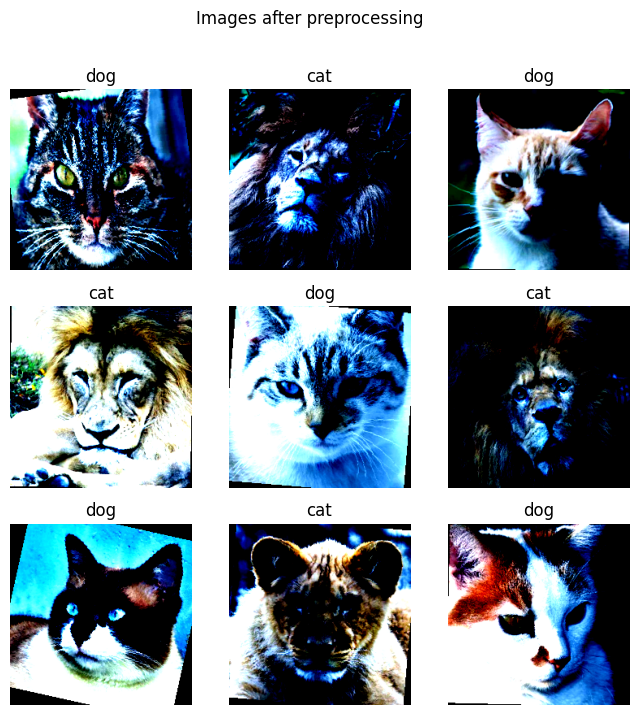

In [8]:
batch_size=32
inputDimension=(224,224)
data_loader(path,batch_size,inputDimension,flag=1)

# Load Trained Model (Without Transfer Learning) & Remove (last) Fully Connected Layer

In [9]:
model1 = torch.load('/kaggle/input/models/COMP6321_ResNet_Task1_CancerDataset_Model_Final_HyperParamaterTuning8.pth')
model1 = torch.nn.Sequential(*(list(model1.children())[:-1]))
model1.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

# T-SNE Plot

In [10]:
# Get embeddings for the test data
def tSNE_plot(temporaryModel, test_loader):
    plt.rcParams.update({'font.size': 55})
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in test_loader:
            images, targets = data[0].to(device), data[1].to(device)
            outputs = temporaryModel(images)
            embeddings.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    
    #Flatten features due to Found array with dim 4. TSNE expected <= 2.
    embeddings = embeddings.reshape(embeddings.shape[0], -1)
    # Apply t-SNE for visualization
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    embeddings_tsne = tsne.fit_transform(embeddings)

      # Plot t-SNE embeddings
    plt.figure(figsize=(30,15))

    for i in range(len(labels_map)):
        plt.scatter(embeddings_tsne[labels==i,0], embeddings_tsne[labels==i,1], label=f'Class {i}')
    legend = plt.legend()
    for handle in legend.legend_handles:
        handle.set_sizes([400])
    plt.title('t-SNE Embeddings for the Data')
    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.show()
    plt.rcParams.update({'font.size': 10})

# Plot T_SNE before Feature Extraction

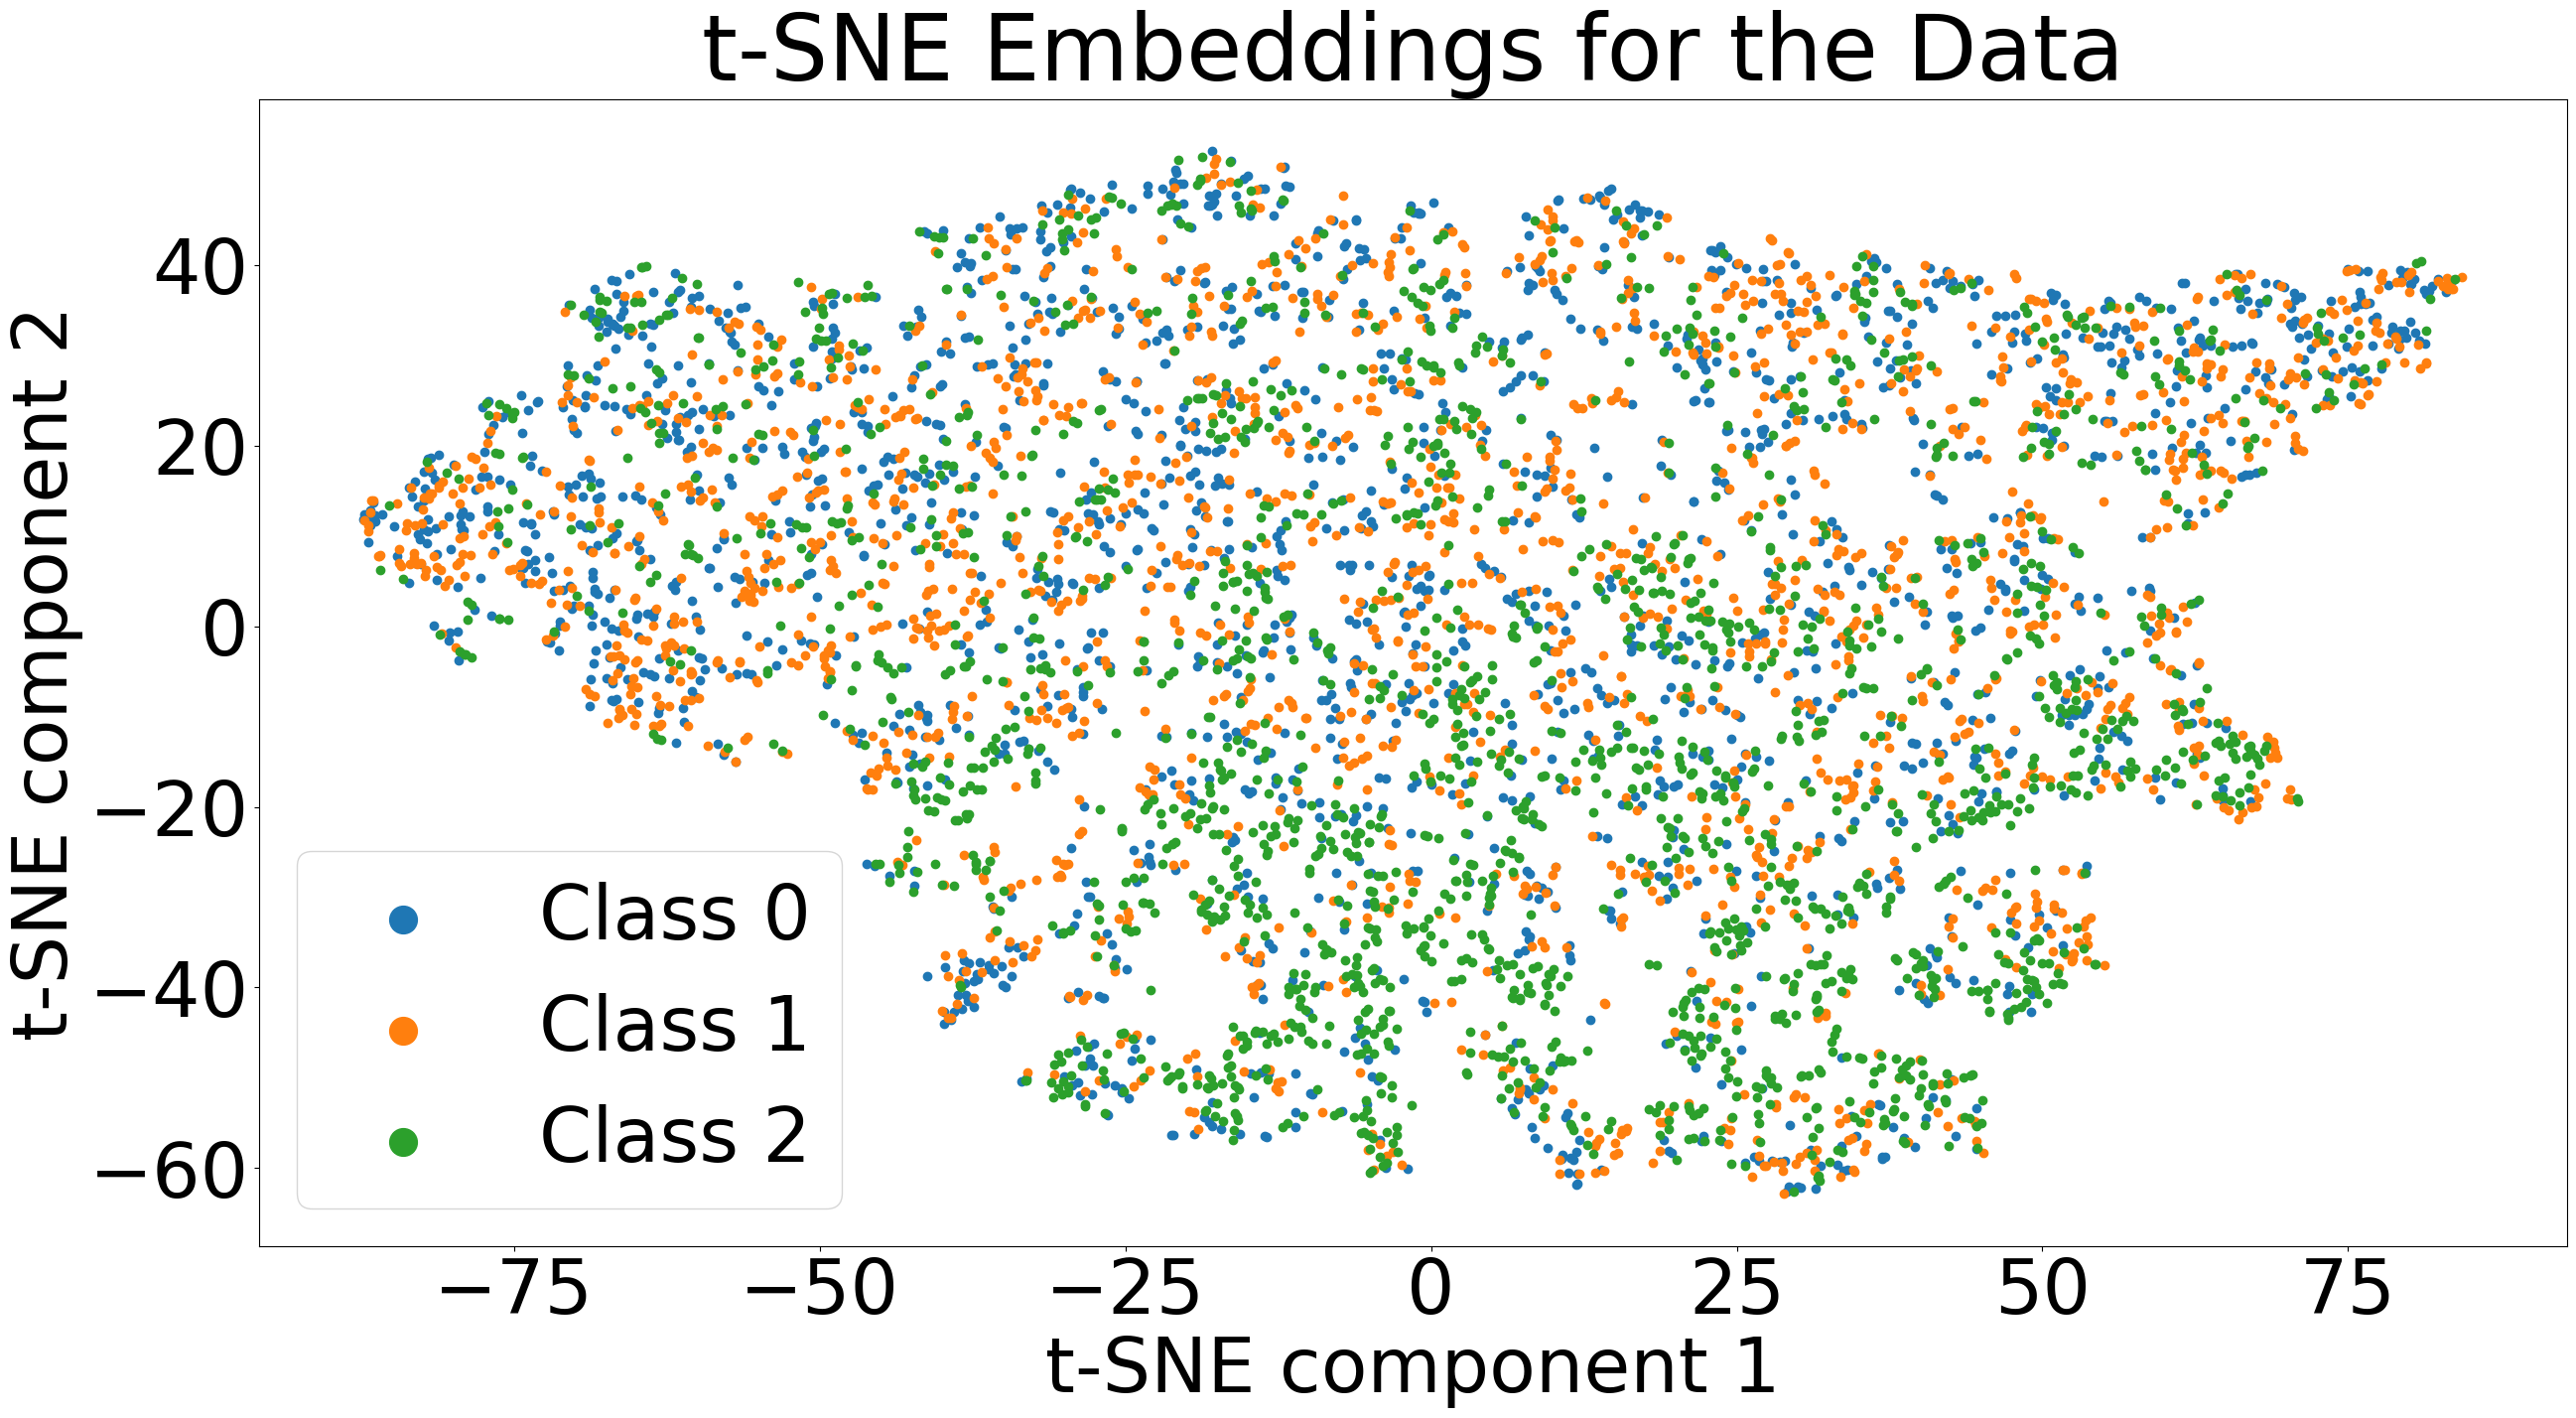

In [11]:
test_loader = data_loader(path,batch_size, inputDimension)
tSNE_plot(model1, test_loader)

# Make Custom Dataset Using Feature Extraction

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from tqdm import tqdm

# Define the transformations
TempTransformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.554, 0.450, 0.343],[0.231, 0.241, 0.241]),
])

# Function to extract features using the model
def extract_features(image_path, model, device):
    image = Image.open(image_path)
    with torch.no_grad():
        features = model(TempTransformer(image).unsqueeze(0).to(device))
    image.close()
    return features.cpu().numpy().flatten()

# Define the images
images = []
enu = range(len(subDirectories))
labels_map={}
for enu,subDirectory in enumerate(subDirectories):
    labels_map.update({enu:subDirectory})
for j in subDirectories:
    for i in os.listdir(new_path+'/'+j):
        images.append(new_path+'/'+j+'/'+i)

# Load the model and set to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = model1.to(device).eval()

# Extract features for each image
all_features = []
for i, image_path in enumerate(tqdm(images)):
    features = extract_features(image_path, model1, device)
    all_features.append(features)

# Convert the features to a DataFrame
columns = [f"feature_{i}" for i in range(len(all_features[0]))]
df = pd.DataFrame(all_features, columns=columns)

# Save the features to a CSV file
df.to_csv("extracted_features.csv", index=False)
print("Features saved to 'extracted_features.csv'.")


100%|██████████| 6000/6000 [01:13<00:00, 81.53it/s]


Features saved to 'extracted_features.csv'.


# Extracted 512 Features

In [13]:
df.head(5)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
0,1.139201,1.130538,2.362670,1.632253,0.209288,1.919847,2.938063,1.415254,0.235426,0.328211,...,0.636332,1.068359,0.498460,0.163303,1.181472,0.380491,1.222177,0.086138,3.064078,0.002764
1,2.511321,1.332309,2.924234,1.638918,0.080112,1.758002,4.019112,2.081048,0.255955,0.145206,...,0.220623,0.780127,1.338939,0.024593,0.853562,0.312892,1.072528,0.363881,3.325452,0.024927
2,2.814345,2.783978,4.852260,1.984882,0.081388,2.926306,4.875617,1.281101,0.353471,0.079339,...,0.081759,0.676808,0.595122,0.030942,1.741377,0.271027,1.653522,0.058494,4.240195,0.013006
3,2.845247,3.340688,3.628712,1.693437,0.033038,2.965055,3.102699,0.966914,0.567211,0.034518,...,0.438350,1.012876,0.201144,0.069620,1.666301,0.014227,1.357575,0.000000,3.191340,0.000153
4,1.365806,1.005209,0.821640,0.875487,0.116068,0.995093,1.356257,1.269752,0.430189,0.087959,...,0.485191,0.849341,0.284684,0.163645,0.972710,0.023623,1.012614,0.040316,1.453666,0.060326


# Add Labels to Extracted Features

In [14]:
import csv

with open('/kaggle/working/extracted_features.csv') as fpi, open('final_features.csv', 'w') as fpo:
    reader = csv.reader(fpi)
    writer = csv.writer(fpo)

    #optionaly handle csv header
    headers = next(reader)
    headers.append('labels')
    writer.writerow(headers)

    for index, row in enumerate(tqdm(reader)):
        if(index>=0 and index<=1999):
            row.append(0)
        elif(index>=2000 and index<=3999):
            row.append(1)
        else:
            row.append(2)
        writer.writerow(row)

6000it [00:01, 3100.36it/s]


# Implement Support Vector Machine (SVM)

Accuarcy of SVM for classification is 69.0%
              precision    recall  f1-score   support

         0.0       0.63      0.69      0.66       385
         1.0       0.77      0.78      0.77       393
         2.0       0.67      0.60      0.64       422

    accuracy                           0.69      1200
   macro avg       0.69      0.69      0.69      1200
weighted avg       0.69      0.69      0.69      1200



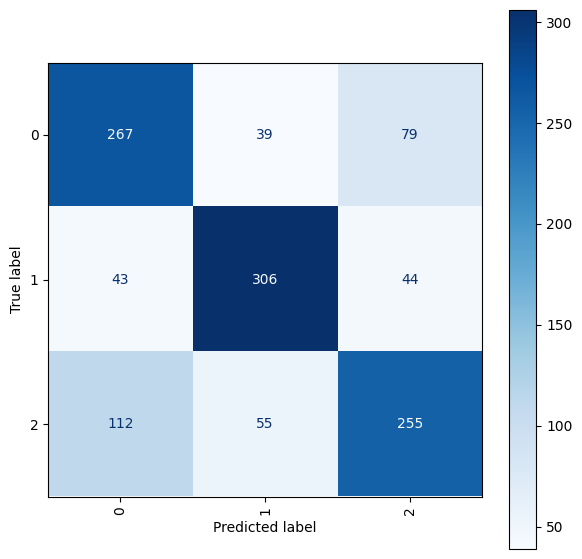

In [15]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
  
# loading the dataset
data =  pd.read_csv('/kaggle/working/final_features.csv', skiprows = 1).to_numpy()
X = data[:,:-1]

y = data[:,-1]
# X -> features, y -> label
  
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state = 0)
  
# training a linear SVM classifier
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)
  
# model accuracy for X_test  
accuracy = svm_model_linear.score(X_test, y_test)
print(f'Accuarcy of SVM for classification is {accuracy * 100}%') 

# creating a confusion matrix
cmReturned = confusion_matrix(y_test, svm_predictions)
print(classification_report(y_test, svm_predictions))
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay(cmReturned).plot(ax=ax,cmap='Blues', xticks_rotation='vertical', values_format='d')
plt.show()

### T-SNE for Visualizing (Color based on Predictions of SVM not original labels)

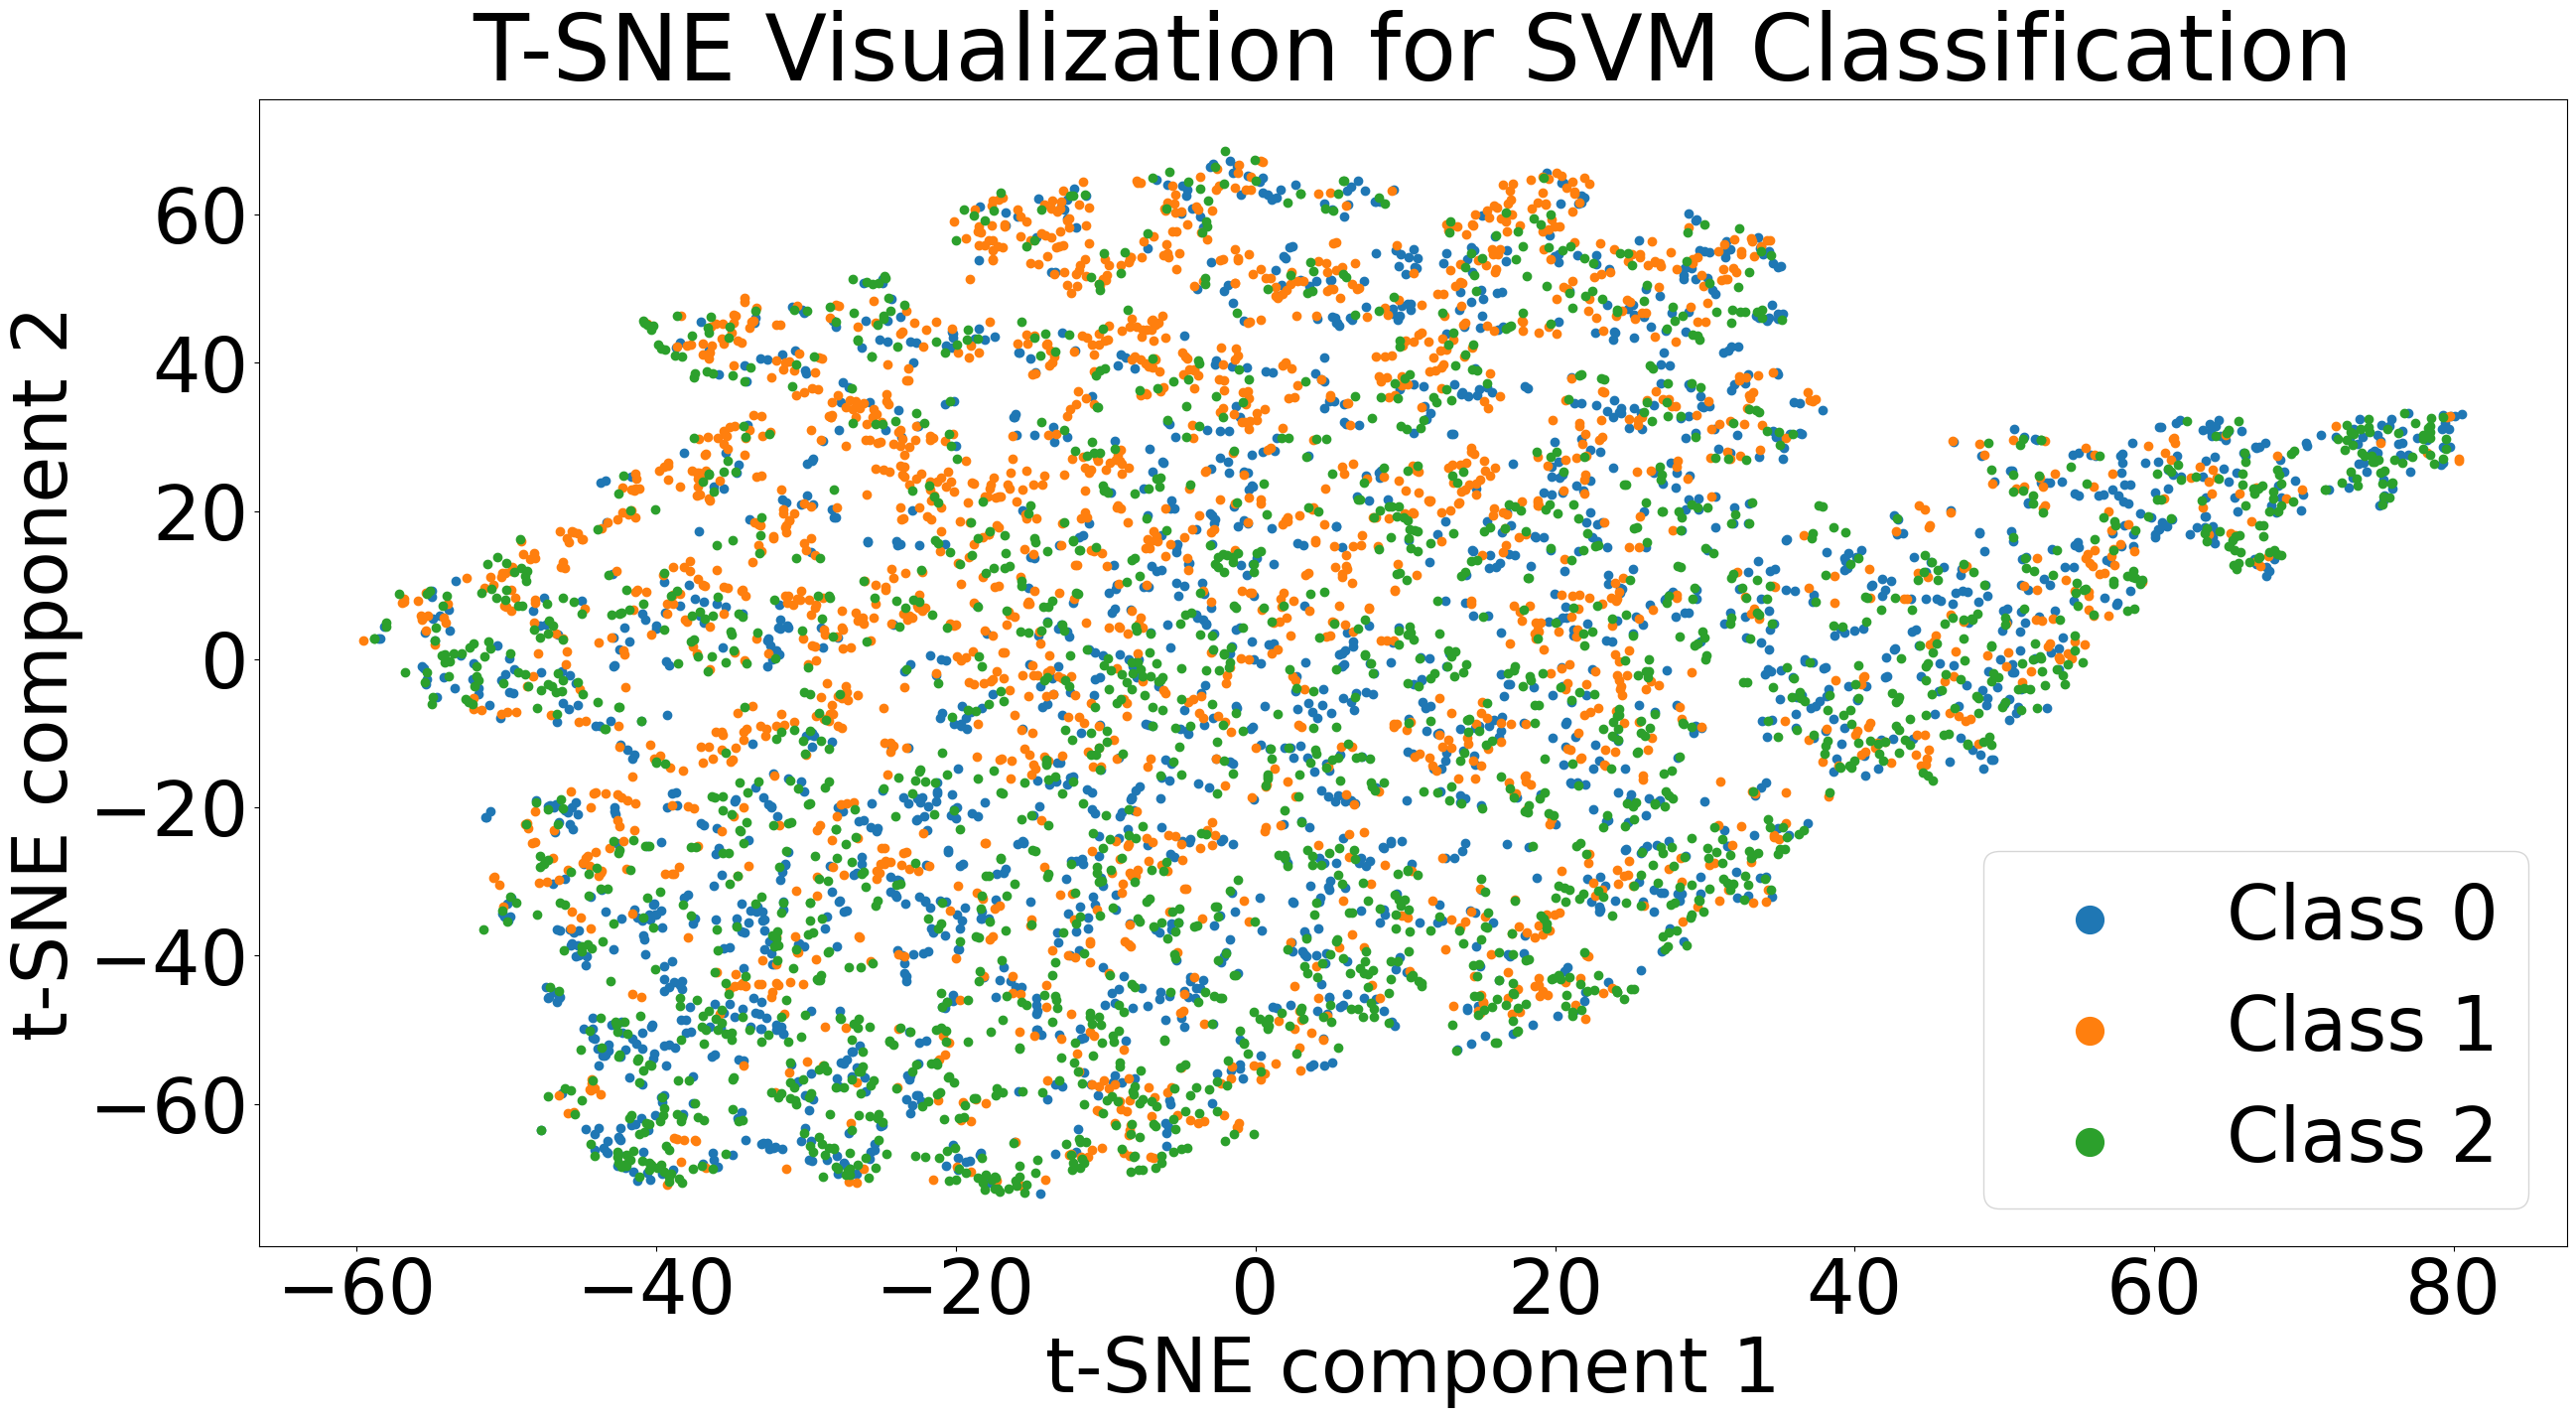

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
#Make a scatter plot with X_embedded

#TODO: Define the TSNE and transform your data into a 2D embedding space
from sklearn.manifold import TSNE
plt.rcParams.update({'font.size': 55})
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

classes=list(set(y))
plt.figure(figsize=(30, 15))

for cl in classes:
    indices = np.where(y==cl)[0]
    plt.title('T-SNE Visualization for SVM Classification')
    plt.scatter(X_embedded[indices,0], X_embedded[indices, 1], label=f'Class {int(cl)}')
    plt.ylabel('t-SNE component 2')
    plt.xlabel('t-SNE component 1')
legend = plt.legend()
for handle in legend.legend_handles:
        handle.set_sizes([400])
plt.rcParams.update({'font.size': 10})